In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from src.visualize import *

In [2]:
# Define a function to get the first half of a colormap
lvls = 25
def half_colormap(cm_name):
    cm = plt.colormaps.get_cmap(cm_name)
    colors = cm(np.linspace(0.1, 0.55, lvls))  # Subsample the colormap by taking every 'step' colors
    new_cm = mcolors.LinearSegmentedColormap.from_list(cm_name + "_subsample", colors)
    new_cm_r = mcolors.LinearSegmentedColormap.from_list(cm_name + "_subsample", colors[::-1])
    return new_cm, new_cm_r

# Create a colormap that is the first half of the "Blues" colormap
half_blues, half_blues_r = half_colormap("Blues")

The following cell recreates Fig.5 in the paper

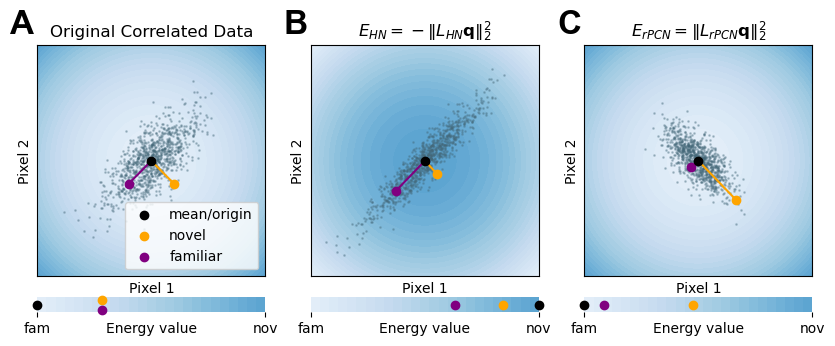

In [3]:
Sigma = np.array([[1, 0.7], [0.7, 1]])
mu = np.array([0, 0])
# sample from a multivariate normal distribution
X = np.random.multivariate_normal(mu, Sigma, 1000) # shape = (1000, 2)
nov = np.array([1, -1])
fam = np.array([-1, -1])

mu_color = 'k'
nov_color = 'orange'
fam_color = 'purple'

# making contour
cmap = half_blues
cmap_r = half_blues_r
# cmap = 'cool'
# cmap_r = cmap + '_r'
# Create grid and multivariate normal
a = np.linspace(-5, 5, 500)
b = np.linspace(-5, 5, 500)
A, B = np.meshgrid(a, b)


# Compute the function values to create a circle.
Z = A**2 + B**2
# whiten the data using ZCA whitening
# first, calculate the covariance matrix
S = np.cov(X.T)
# second, calculate the eigenvalues and eigenvectors of the covariance matrix
eigval, eigvec = np.linalg.eig(S)


# Hopfield like transformation
W_HN = eigvec.dot(np.diag(eigval**(0.5))).dot(eigvec.T)
X_HN = W_HN.dot(X.T)
nov_HN = W_HN.dot(nov)
fam_HN = W_HN.dot(fam)

# Transformation by the inverse of the covariance matrix
S_inv = np.linalg.inv(S)
# transform the data
X_inv = S_inv.dot(X.T)
nov_inv = S_inv.dot(nov)
fam_inv = S_inv.dot(fam)

# Transformation by implicit PCN
W_imp = (np.diag(np.ones(shape=(2,)) / np.diag(S_inv))).dot(S_inv)
X_imp = W_imp.dot(X.T)
nov_imp = W_imp.dot(nov)
fam_imp = W_imp.dot(fam)

# plot the data
dot_c = '#446879'
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
add_panel_letters(ax)
# plot the contour
contours = []
contours.append(ax[0].contourf(A, B, Z, levels=25, cmap=cmap, alpha=1))
contours.append(ax[1].contourf(A, B, Z, levels=25, cmap=cmap_r, alpha=1))
contours.append(ax[2].contourf(A, B, Z, levels=25, cmap=cmap, alpha=1))

ax[0].scatter(X[:, 0], X[:, 1], s=1, alpha=0.3, c=dot_c)
ax[0].set_title(r'Original Correlated Data')
ax[1].scatter(X_HN[0, :], X_HN[1, :], s=1, alpha=0.3, c=dot_c)
ax[1].set_title(r'$E_{HN}=-\|L_{HN}\mathbf{q}\|_2^2$')
ax[2].scatter(X_imp[0, :], X_imp[1, :], s=1, alpha=0.3, c=dot_c)
ax[2].set_title(r'$E_{rPCN}=\|L_{rPCN}\mathbf{q}\|_2^2$')

# plot the novel and familiar points


ax[0].scatter(mu[0], mu[1], s=36, c=mu_color, label='mean/origin',zorder=3)
ax[0].scatter(nov[0], nov[1], s=36, c=nov_color, label='novel')
ax[0].scatter(fam[0], fam[1], s=36, c=fam_color, label='familiar')
ax[0].legend()

ax[1].scatter(mu[0], mu[1], s=36, c=mu_color, label='mean/origin',zorder=3)
ax[1].scatter(nov_HN[0], nov_HN[1], s=36, c=nov_color)
ax[1].scatter(fam_HN[0], fam_HN[1], s=36, c=fam_color)
ax[2].scatter(mu[0], mu[1], s=36, c=mu_color, label='mean/origin',zorder=3)
ax[2].scatter(nov_imp[0], nov_imp[1], s=36, c=nov_color)
ax[2].scatter(fam_imp[0], fam_imp[1], s=36, c=fam_color)

# in all subplots, visualze the distance from the novel and familiar points to the origin
ax[0].plot([0, nov[0]], [0, nov[1]], c=nov_color)
ax[0].plot([0, fam[0]], [0, fam[1]], c=fam_color)
ax[1].plot([0, nov_HN[0]], [0, nov_HN[1]], c=nov_color)
ax[1].plot([0, fam_HN[0]], [0, fam_HN[1]], c=fam_color)
ax[2].plot([0, nov_imp[0]], [0, nov_imp[1]], c=nov_color)
ax[2].plot([0, fam_imp[0]], [0, fam_imp[1]], c=fam_color)


lim = 5

# Example adjustments for separate colorbars under each subplot
for i, ax_i in enumerate(ax):  # Loop through each subplot axis
    
    # Extract the position of the current subplot to place the colorbar correctly
    pos = ax_i.get_position()  # Get the bounding box in figure coordinates
    
    thickness = 0.05 # Set the thickness of the colorbar

    # Adjust the `left`, `bottom`, `width`, and `height` accordingly
    cbar_ax = fig.add_axes([pos.x0, pos.y0 - 0.12, pos.width, thickness])  # Adjust the two numbers as needed
    
    # Create a colorbar in the new axes based on the contour from the subplot
    if i == 0:
        cbar = fig.colorbar(contours[i], cax=cbar_ax, orientation='horizontal')  # Use horizontal orientation
        origin_cbar_pos = np.linalg.norm(mu)/lim
        nov_cbar_pos = np.linalg.norm(nov)/lim
        fam_cbar_pos = np.linalg.norm(fam)/lim
    elif i == 1:
        cbar = fig.colorbar(contours[0], cax=cbar_ax, orientation='horizontal')
        origin_cbar_pos = (lim - np.linalg.norm(mu))/lim
        nov_cbar_pos = (lim - np.linalg.norm(nov_HN))/lim
        fam_cbar_pos = (lim - np.linalg.norm(fam_HN))/lim
    elif i == 2:
        cbar = fig.colorbar(contours[i], cax=cbar_ax, orientation='horizontal')  # Use horizontal orientation
        origin_cbar_pos = np.linalg.norm(mu)/lim
        nov_cbar_pos = np.linalg.norm(nov_imp)/lim
        fam_cbar_pos = np.linalg.norm(fam_imp)/lim
    
    cbar.ax.plot(origin_cbar_pos, 0.5, 'o', color=mu_color, clip_on=False, transform=cbar.ax.transAxes)
    if nov_cbar_pos == fam_cbar_pos:
        drift = 6.5*thickness
        cbar.ax.plot(nov_cbar_pos, 0.5+drift, 'o', color=nov_color, clip_on=False, transform=cbar.ax.transAxes)
        cbar.ax.plot(fam_cbar_pos, 0.5-drift, 'o', color=fam_color, clip_on=False, transform=cbar.ax.transAxes)
    else:
        cbar.ax.plot(nov_cbar_pos, 0.5, 'o', color=nov_color, clip_on=False, transform=cbar.ax.transAxes)
        cbar.ax.plot(fam_cbar_pos, 0.5, 'o', color=fam_color, clip_on=False, transform=cbar.ax.transAxes)
    cbar.set_ticks([cbar.vmin, cbar.vmax])
    cbar.set_ticklabels(['fam', 'nov'])
    # Get the bounding box of the colorbar
    cbar_ax_bbox = cbar.ax.get_position()

    # Calculate position for the title (below the colorbar)
    title_x = cbar_ax_bbox.x0 + cbar_ax_bbox.width / 2
    title_y = cbar_ax_bbox.y0 - thickness/1.6  # Adjust this offset as needed

    # Add text below the colorbar
    fig.text(title_x, title_y, 'Energy value', ha='center', va='top')
    cbar.outline.set_visible(False)



for i in range(3):
    ax[i].set_xlim([-lim, lim])
    ax[i].set_xlabel('Pixel 1')
    ax[i].set_ylabel('Pixel 2')
    ax[i].set_ylim([-lim, lim])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    # ax[i].axis('off')
# plt.tight_layout()

result_path = os.path.join('./results/', 'correlation plots')
if not os.path.exists(result_path):
    os.makedirs(result_path)
plt.savefig(result_path+'/decorrelating_main.pdf', format='pdf', bbox_inches='tight')
plt.show()


The following cell recreates Fig.8 in the Appendix

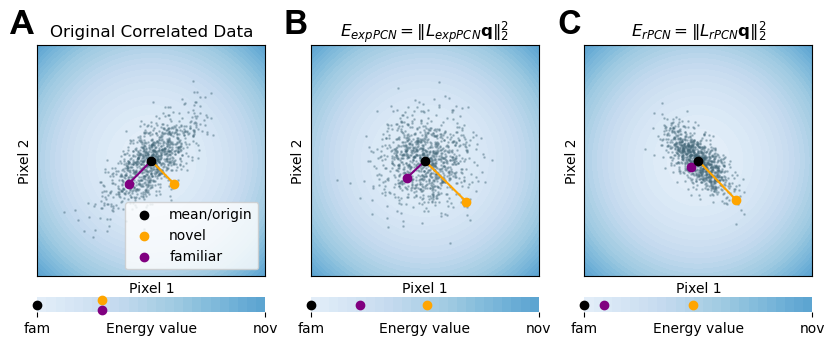

In [4]:

W_exp = eigvec.dot(np.diag(eigval**(-0.5))).dot(eigvec.T)
X_exp = W_exp.dot(X.T)
nov_exp = W_exp.dot(nov.T)
fam_exp = W_exp.dot(fam)

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
add_panel_letters(ax)
# plot the contour
contours = []
contours.append(ax[0].contourf(A, B, Z, levels=25, cmap=cmap, alpha=1))
contours.append(ax[1].contourf(A, B, Z, levels=25, cmap=cmap, alpha=1))
contours.append(ax[2].contourf(A, B, Z, levels=25, cmap=cmap, alpha=1))


ax[0].scatter(X[:, 0], X[:, 1], s=1, alpha=0.3, c=dot_c)
ax[0].set_title(r'Original Correlated Data')
ax[1].scatter(X_exp[0, :], X_exp[1, :], s=1, alpha=0.3, c=dot_c)
ax[1].set_title(r'$E_{expPCN}=\|L_{expPCN}\mathbf{q}\|_2^2$')
ax[2].scatter(X_imp[0, :], X_imp[1, :], s=1, alpha=0.3, c=dot_c)
ax[2].set_title(r'$E_{rPCN}=\|L_{rPCN}\mathbf{q}\|_2^2$')


# plot the novel and familiar points


ax[0].scatter(mu[0], mu[1], s=36, c=mu_color, label='mean/origin',zorder=3)
ax[0].scatter(nov[0], nov[1], s=36, c=nov_color, label='novel')
ax[0].scatter(fam[0], fam[1], s=36, c=fam_color, label='familiar')
ax[0].legend()

ax[1].scatter(mu[0], mu[1], s=36, c=mu_color, label='mean/origin',zorder=3)
ax[1].scatter(nov_exp[0], nov_exp[1], s=36, c=nov_color)
ax[1].scatter(fam_exp[0], fam_exp[1], s=36, c=fam_color)

ax[2].scatter(mu[0], mu[1], s=36, c=mu_color, label='mean/origin',zorder=3)
ax[2].scatter(nov_imp[0], nov_imp[1], s=36, c=nov_color)
ax[2].scatter(fam_imp[0], fam_imp[1], s=36, c=fam_color)




# in all subplots, visualze the distance from the novel and familiar points to the origin
ax[0].plot([0, nov[0]], [0, nov[1]], c=nov_color)
ax[0].plot([0, fam[0]], [0, fam[1]], c=fam_color)
ax[1].plot([0, nov_exp[0]], [0, nov_exp[1]], c=nov_color)
ax[1].plot([0, fam_exp[0]], [0, fam_exp[1]], c=fam_color)
ax[2].plot([0, nov_imp[0]], [0, nov_imp[1]], c=nov_color)
ax[2].plot([0, fam_imp[0]], [0, fam_imp[1]], c=fam_color)


lim = 5

# Example adjustments for separate colorbars under each subplot
for i, ax_i in enumerate(ax):  # Loop through each subplot axis
    
    # Extract the position of the current subplot to place the colorbar correctly
    pos = ax_i.get_position()  # Get the bounding box in figure coordinates
    
    thickness = 0.05 # Set the thickness of the colorbar

    # Adjust the `left`, `bottom`, `width`, and `height` accordingly
    cbar_ax = fig.add_axes([pos.x0, pos.y0 - 0.12, pos.width, thickness])  # Adjust the two numbers as needed
    
    # Create a colorbar in the new axes based on the contour from the subplot
    if i == 0:
        cbar = fig.colorbar(contours[i], cax=cbar_ax, orientation='horizontal')  # Use horizontal orientation
        origin_cbar_pos = np.linalg.norm(mu)/lim
        nov_cbar_pos = np.linalg.norm(nov)/lim
        fam_cbar_pos = np.linalg.norm(fam)/lim
    elif i == 1:
        cbar = fig.colorbar(contours[i], cax=cbar_ax, orientation='horizontal')
        origin_cbar_pos = np.linalg.norm(mu)/lim
        nov_cbar_pos = np.linalg.norm(nov_exp)/lim
        fam_cbar_pos = np.linalg.norm(fam_exp)/lim
    elif i == 2:
        cbar = fig.colorbar(contours[i], cax=cbar_ax, orientation='horizontal')  # Use horizontal orientation
        origin_cbar_pos = np.linalg.norm(mu)/lim
        nov_cbar_pos = np.linalg.norm(nov_imp)/lim
        fam_cbar_pos = np.linalg.norm(fam_imp)/lim
    
    
    cbar.ax.plot(origin_cbar_pos, 0.5, 'o', color=mu_color, clip_on=False, transform=cbar.ax.transAxes)
    if nov_cbar_pos == fam_cbar_pos:
        drift = 6.5*thickness
        cbar.ax.plot(nov_cbar_pos, 0.5+drift, 'o', color=nov_color, clip_on=False, transform=cbar.ax.transAxes)
        cbar.ax.plot(fam_cbar_pos, 0.5-drift, 'o', color=fam_color, clip_on=False, transform=cbar.ax.transAxes)
    else:
        cbar.ax.plot(nov_cbar_pos, 0.5, 'o', color=nov_color, clip_on=False, transform=cbar.ax.transAxes)
        cbar.ax.plot(fam_cbar_pos, 0.5, 'o', color=fam_color, clip_on=False, transform=cbar.ax.transAxes)
    cbar.set_ticks([cbar.vmin, cbar.vmax])
    cbar.set_ticklabels(['fam', 'nov'])
    # Get the bounding box of the colorbar
    cbar_ax_bbox = cbar.ax.get_position()            
    # Calculate position for the title (below the colorbar)
    title_x = cbar_ax_bbox.x0 + cbar_ax_bbox.width / 2
    title_y = cbar_ax_bbox.y0 - thickness/1.6  # Adjust this offset as needed

    # Add text below the colorbar
    fig.text(title_x, title_y, 'Energy value', ha='center', va='top')
    cbar.outline.set_visible(False)



for i in range(3):
    ax[i].set_xlim([-lim, lim])
    ax[i].set_xlabel('Pixel 1')
    ax[i].set_ylabel('Pixel 2')
    ax[i].set_ylim([-lim, lim])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    # ax[i].axis('off')
# plt.tight_layout()
result_path = os.path.join('./results/', 'correlation plots')
if not os.path.exists(result_path):
    os.makedirs(result_path)
plt.savefig(result_path+'/decorrelating_appendix.pdf', format='pdf', bbox_inches='tight')
plt.show()

